# tensorflow: Training Neural Networks for Classification and Dimensionality Reduction

This notebook demonstrates example neural network setups for **image classification** and **dimensionality reduction** tasks using `tensorflow`.

The examples serve as complement and comparison for exploring neural networks with the `edu.yaprnn` app.

### TensorFlow on Windows: Virtual Environment Setup

To ensure TensorFlow compatibility on Windows, use the script `setup-venv-tensorflow-2.10.1.sh` to create a dedicated Python virtual environment with TensorFlow version `2.10.1`.

Loading MNIST images from E:\edu.yaprnn\src\main\resources\digits.idx3-ubyte


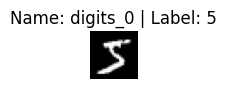

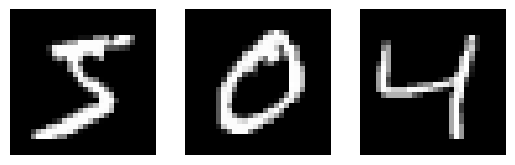

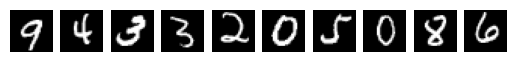

(36000, 784) (36000, 10) (36000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)


In [1]:
from sklearn.model_selection import train_test_split

import mnist_utils
import model_utils

mnist_images, image_size, X, random_x_indices, random_feature_indices, y, labels = mnist_utils.from_mnist_images()

digits_train_32k_test_12k = train_test_split(X, y, labels, train_size=0.6, test_size=0.2, random_state=model_utils.SEED)
digits_images_from_labels = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=model_utils.SEED)
digits_input_reconstruction = train_test_split(X, y, labels, train_size=0.8, test_size=0.2,
                                               random_state=model_utils.SEED)

mnist_utils.from_dataset(digits_train_32k_test_12k, explain=True)
mnist_utils.from_dataset(digits_images_from_labels, explain=True)
mnist_utils.from_dataset(digits_input_reconstruction, explain=True)

None

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import L1L2
import numpy as np
import tensorflow as tf

def ssim_metric(y_true, y_pred):
    y_true_reshaped = tf.reshape(y_true, [-1, image_size[0], image_size[1], 1])
    y_pred_reshaped = tf.reshape(y_pred, [-1, image_size[0], image_size[1], 1])
    return tf.reduce_mean(tf.image.ssim(y_true_reshaped, y_pred_reshaped, max_val=1.0))

# Digits Classification

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 2 hidden layers:
    - Layer 1: 20 neurons
    - Layer 2: 15 neurons
  - Output layer: 10 neurons
  - Total parameters: `((784 + 1) * 20) + ((20 + 1) * 15) + ((15 + 1) * 10) = 16175` (Biases included)
- **Activation Function**: gelu
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02 / 32 (=batch_size)
  - Momentum: 0.2 with Nesterov term
  - L1-weight-decay: 0.001
  - L2-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

In [3]:
input_size, output_size, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)

classification_optimizer = SGD(learning_rate=model_utils.BATCH_LEARNING_RATE, momentum=model_utils.MOMENTUM,
                               nesterov=model_utils.NESTEROV_MOMENTUM)
classification_loss = 'mse'
classification_regularizer = L1L2(l1=model_utils.L1_DECAY, l2=model_utils.L2_DECAY)

classification_model = Sequential([
    Dense(model_utils.CLASSIFICATION_FEATURES[0], activation='gelu', input_shape=(input_size,),
          kernel_regularizer=classification_regularizer),
    Dense(model_utils.CLASSIFICATION_FEATURES[1], activation='gelu', kernel_regularizer=classification_regularizer),
    Dense(output_size, activation='gelu', kernel_regularizer=classification_regularizer)
])
classification_model.compile(optimizer=classification_optimizer, loss=classification_loss, metrics=['accuracy'])
classification_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=model_utils.CLASSIFICATION_EPOCHS,
                         batch_size=model_utils.BATCH_SIZE)

classification_model_predict = lambda X: classification_model.predict(X)

print(f'Actual number of parameters: {classification_model.count_params()}')

Epoch 1/50
1125/1125 [==============================] - 1s 700us/step - loss: 0.9440 - accuracy: 0.1228 - val_loss: 0.9334 - val_accuracy: 0.1311
Epoch 2/50
1125/1125 [==============================] - 1s 609us/step - loss: 0.9232 - accuracy: 0.1357 - val_loss: 0.9133 - val_accuracy: 0.1478
Epoch 3/50
1125/1125 [==============================] - 1s 620us/step - loss: 0.9037 - accuracy: 0.1570 - val_loss: 0.8942 - val_accuracy: 0.1704
Epoch 4/50
1125/1125 [==============================] - 1s 599us/step - loss: 0.8849 - accuracy: 0.1799 - val_loss: 0.8758 - val_accuracy: 0.1946
Epoch 5/50
1125/1125 [==============================] - 1s 609us/step - loss: 0.8668 - accuracy: 0.2062 - val_loss: 0.8578 - val_accuracy: 0.2223
Epoch 6/50
1125/1125 [==============================] - 1s 608us/step - loss: 0.8490 - accuracy: 0.2335 - val_loss: 0.8402 - val_accuracy: 0.2503
Epoch 7/50
1125/1125 [==============================] - 1s 603us/step - loss: 0.8316 - accuracy: 0.2627 - val_loss: 0.8230 -

1125/1125 [==============================] - 0s 349us/step
Accuracy on training set: 0.6152777777777778
375/375 [==============================] - 0s 343us/step
Accuracy on test set: 0.6138333333333333
Random test indices: [11890  7796  1979  3554 10223]


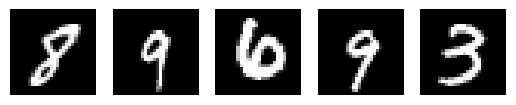

Actual labels of random test indices: [8 9 6 9 3]
1/1 [==============================] - 0s 38ms/step
Predicted labels of random test indices: [1 9 2 9 3]


array([['0.03', '0.18', '0.1', '0.1', '0.11', '0.09', '0.08', '0.14',
        '0.17', '0.1'],
       ['-0.02', '0.15', '-0.01', '0.07', '0.17', '0.08', '0.04', '0.12',
        '0.12', '0.18'],
       ['0.26', '0.1', '0.26', '0.12', '0.09', '0.01', '0.2', '0.05',
        '0.03', '0.01'],
       ['-0.03', '0.14', '-0.02', '0.07', '0.16', '0.08', '0.05', '0.16',
        '0.15', '0.21'],
       ['0.08', '0.07', '-0.0', '0.27', '-0.01', '0.15', '0.09', '-0.05',
        '0.14', '0.11']], dtype='<U32')

In [4]:
_, _, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)

print(f'Accuracy on training set: {model_utils.calculate_accuracy(classification_model_predict, X_train, y_train)}')
print(f'Accuracy on test set: {model_utils.calculate_accuracy(classification_model_predict, X_test, y_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
print(f'Random test indices: {random_test_indices}')

mnist_utils.plot_images(X_test[random_test_indices], image_size=image_size, cmap='gray')
print(f'Actual labels of random test indices: {np.argmax(y_test[random_test_indices], axis=1)}')

predicted = classification_model_predict(X_test[random_test_indices])
print(f'Predicted labels of random test indices: {np.argmax(predicted, axis=1)}')
predicted.round(2).astype('str')

## Dimensionality Reduction with an Autoencoder

This section demonstrates the use of two neural networks for dimensionality reduction. These networks rely on a bottleneck layer in their architecture to reduce the input data's dimensionality.

Instead of using predefined methods to extract the most relevant features, the networks are trained using backpropagation. This approach enables the model to automatically learn a transformation into a compressed feature space along with its inverse transformation to reconstruct the input data as accurately as possible.

### Shallow Autoencoder Network with 12 Neurons Bottleneck Layer

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 5 hidden layers:
    - Layer 1: 196 neurons
    - Layer 2: 49 neurons
    - Layer 3: 12 neurons
    - Layer 4: 49 neurons
    - Layer 5: 196 neurons
  - Output layer: 784 neurons
  - Total parameters: 328998 (Biases included)
- **Activation Function**: Gaussian Error Linear Unit (GeLU)
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02
  - Momentum: 0.2 with Nesterov term
  - L1-weight-decay: 0.001
  - L2-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

In [5]:
input_size, _, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)

autoencoder_optimizer = SGD(learning_rate=model_utils.BATCH_LEARNING_RATE, momentum=model_utils.MOMENTUM,
                            nesterov=model_utils.NESTEROV_MOMENTUM)
autoencoder_loss = 'mse'
autoencoder_regularizer = L1L2(l1=model_utils.L1_DECAY, l2=model_utils.L2_DECAY)

autoencoder_model = Sequential([
    Dense(model_utils.AUTOENCODER_FEATURES[0], activation='gelu', input_shape=(input_size,),
          kernel_regularizer=autoencoder_regularizer),
    Dense(model_utils.AUTOENCODER_FEATURES[1], activation='gelu', kernel_regularizer=autoencoder_regularizer),
    Dense(model_utils.AUTOENCODER_FEATURES[2], activation='gelu', kernel_regularizer=autoencoder_regularizer),
    Dense(model_utils.AUTOENCODER_FEATURES[3], activation='gelu', kernel_regularizer=autoencoder_regularizer),
    Dense(model_utils.AUTOENCODER_FEATURES[4], activation='gelu', kernel_regularizer=autoencoder_regularizer),
    Dense(input_size, activation='gelu', kernel_regularizer=autoencoder_regularizer)
])
autoencoder_model.compile(optimizer=autoencoder_optimizer, loss=autoencoder_loss, metrics=[ssim_metric])
autoencoder_model.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=model_utils.AUTOENCODER_EPOCHS,
                      batch_size=model_utils.BATCH_SIZE)

autoencoder_model_predict = lambda X: autoencoder_model.predict(X)

print(f'Actual number of parameters: {autoencoder_model.count_params()}')

Epoch 1/100
1500/1500 [==============================] - 13s 8ms/step - loss: 14.4412 - ssim_metric: 0.0971 - val_loss: 14.2169 - val_ssim_metric: 0.0972
Epoch 2/100
1500/1500 [==============================] - 14s 9ms/step - loss: 13.9964 - ssim_metric: 0.0977 - val_loss: 13.7759 - val_ssim_metric: 0.0977
Epoch 3/100
1500/1500 [==============================] - 12s 8ms/step - loss: 13.5591 - ssim_metric: 0.0981 - val_loss: 13.3425 - val_ssim_metric: 0.0982
Epoch 4/100
1500/1500 [==============================] - 12s 8ms/step - loss: 13.1295 - ssim_metric: 0.0986 - val_loss: 12.9166 - val_ssim_metric: 0.0986
Epoch 5/100
1500/1500 [==============================] - 12s 8ms/step - loss: 12.7074 - ssim_metric: 0.0989 - val_loss: 12.4982 - val_ssim_metric: 0.0989
Epoch 6/100
1500/1500 [==============================] - 12s 8ms/step - loss: 12.2927 - ssim_metric: 0.0992 - val_loss: 12.0873 - val_ssim_metric: 0.0992
Epoch 7/100
1500/1500 [==============================] - 15s 10ms/step - los

1500/1500 [==============================] - 1s 739us/step
Loss X_train: 0.1053156927227974
375/375 [==============================] - 0s 880us/step
Loss X_test: 0.10489105433225632
Random test indices: [11524  5194  3729  3197  9430]


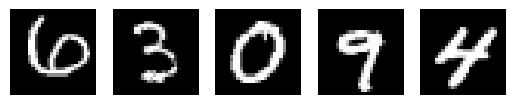

1/1 [==============================] - 0s 51ms/step


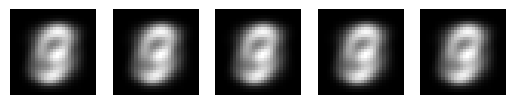

In [6]:
_, _, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)

print(f'Loss X_train: {model_utils.mse_loss(autoencoder_model_predict, X_train, X_train)}')
print(f'Loss X_test: {model_utils.mse_loss(autoencoder_model_predict, X_test, X_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
print(f'Random test indices: {random_test_indices}')

original = X_test[random_test_indices]
mnist_utils.plot_images(original, image_size=image_size, cmap='gray')

restored = autoencoder_model_predict(original)
mnist_utils.plot_images(restored, image_size=image_size, cmap='gray')